# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Домашнее задание 5

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

---
### Задача 3.


**Профиль Физика**

Скачайте <a target="_blank" href="https://www.kaggle.com/datasets/fedesoriano/cern-electron-collision-data">данные</a> столкновениях частиц и оставьте следующие признаки:
* `E1`, `E2` &mdash; полная энергия электронов (ГэВ);
* `M` &mdash; инвариантная масса двух электронов (ГэВ).


**1.** Постройте для каждого из признаков гистограммы. Что можно сказать о характере распределения?


In [4]:
df = pd.read_csv('dielectron.csv')[['E1', 'E2', 'M']]
df

,E1,E2,M
0,58.71410,11.28360,8.94841
1,6.61188,17.14920,15.89300
2,25.54190,15.82030,38.38770
3,65.39590,25.12730,3.72862
4,61.45040,13.88710,2.74718
...,...,...,...
99995,12.31310,1.80181,8.44779
99996,18.46420,14.69110,20.71540
99997,4.18566,72.81740,12.71350
99998,54.46220,8.58671,4.69670


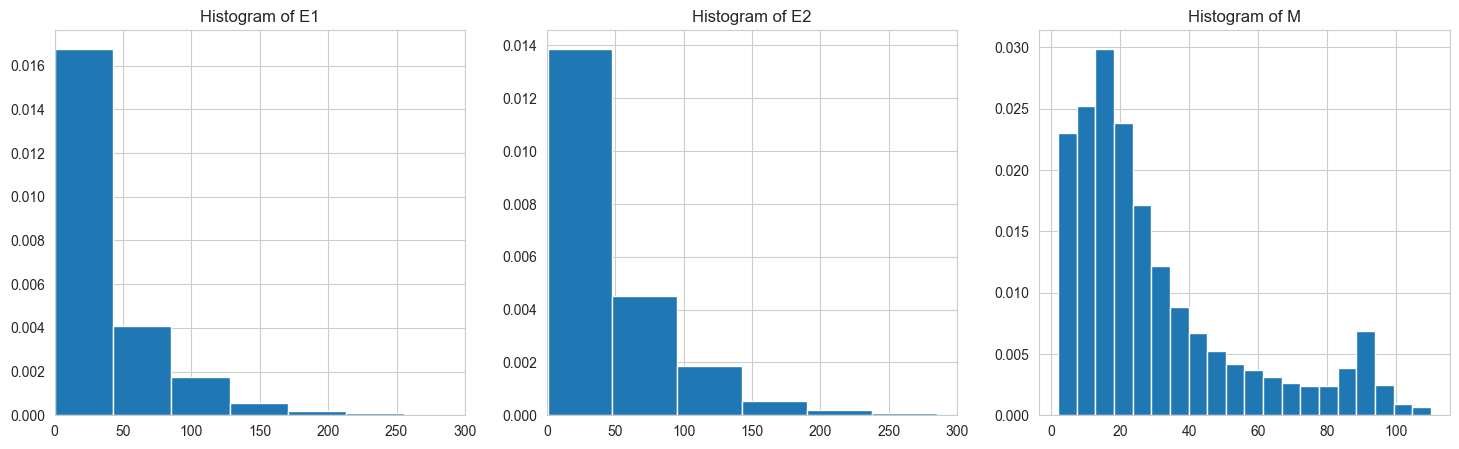

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feat in enumerate(['E1', 'E2', 'M']):
    axes[idx].hist(df[feat], bins=20, density=True)
    axes[idx].set_title(f'Histogram of {feat}')

axes[0].set_xlim(0, 300)
axes[1].set_xlim(0, 300)

plt.show()

**Ответ:** 1. Распределение несимметричное. 
           2. Похоже на экспоненциальное распределение. 
           3. В E1 и E2 присутствую выбросы.

**2.** Пусть есть выборка $X_1, ..., X_n$. Опишите процедуру бутстрепа построения доверительного интервала для величины $\theta = \mathsf{E} X_1$. Рассмотрите три типа  бутстрепных доверительных интервалов, выпишите формулу для каждого из них.

**Описание:**

**3.** Реализуйте функцию вычисления выборки оценок $\theta^*_1, \ldots \theta^*_B$ для оценки $\widehat \theta$ методом бутстрепа. Функция должна принимать на вход выборку и количество бутстрепных выборок $B$. 

In [97]:
def estimator(sample):
    '''
    Делает необходимые преобразования с выборкой (выполняет подсчет статистики).
    Используется в функции bootstrap для вычисления оценок.
    
    :param sample: массив с числами
    :return: оценка, посчитанная по выборке
    '''
    return sample.mean(axis=1)


def bootstrap(sample, B=100_000):
    '''
    Реализует процедуру бутстрепа.
    
    :param sample: исходная выборка, по которой будут вычисляться бутстрепные оценки
    :param B: число бутстрепных оценок
    :return: возвращает массив длины B c бутстрепными оценками
    '''
    rng = np.random.default_rng()
    n = len(sample)  # длина выборки
    batch = 100
    boots = np.zeros(B)
    for b in range(B//batch):
        boot_sample = sample[rng.choice(a=n, size=(batch, n))]
        boots[b * batch : (b+1) * batch] = estimator(boot_sample)
    return boots


**4.** Реализуйте три типа бутстрепных доверительных интервалы в виде функций, принимающих на вход выборку оценок, полученных с помощью бутстрепа. Реализовывать вычисление бутстрепных интервалов для подвыборок размера от 1 до n не нужно, только для всей выборки. 

In [98]:
def boostrap_normal_confidence_interval(estimation, bootstrap_estimations, alpha=0.95):
    z = sps.norm.ppf((1 + alpha) / 2)
    v_boot = bootstrap_estimations.std(ddof=0)
    return ((estimation - z * v_boot).round(4), (estimation + z * v_boot).round(4))
    
def boostrap_central_confidence_interval(estimation, bootstrap_estimations, alpha=0.95):
    B = len(bootstrap_estimations)
    left_ind = int(np.ceil(B * (1 + alpha) / 2)) - 1
    right_ind = int(np.floor(B * (1 - alpha) / 2)) - 1
    return ((2 * estimation - bootstrap_estimations[left_ind]).round(4), (2 * estimation - bootstrap_estimations[right_ind]).round(4))
    
def boostrap_quantile_confidence_interval(bootstrap_estimations, alpha=0.95):
    B = len(bootstrap_estimations)
    left_ind = int(np.floor(B * (1 - alpha) / 2)) - 1
    right_ind = int(np.ceil(B * (1 + alpha) / 2)) - 1
    return (bootstrap_estimations[left_ind].round(4), bootstrap_estimations[right_ind].round(4))

In [89]:
a = np.arange(10)
print(a)
rng = np.random.default_rng()
a[rng.choice(a=2, size=(2, 10))]
print(df['E1'].to_numpy())
df['E1'].to_numpy()[rng.choice(a=2, size=(2, 10))]

[0 1 2 3 4 5 6 7 8 9]
[58.7141   6.61188 25.5419  ...  4.18566 54.4622   7.64   ]


array([[ 6.61188,  6.61188,  6.61188,  6.61188, 58.7141 ,  6.61188,
        58.7141 ,  6.61188, 58.7141 ,  6.61188],
       [58.7141 , 58.7141 ,  6.61188, 58.7141 , 58.7141 ,  6.61188,
        58.7141 ,  6.61188,  6.61188,  6.61188]])

**5.** Для каждого признака постройте бутстрепные доверительные интервалы для $\theta = \mathsf{E} X_1$ и сравните их.

In [109]:
intervals = {}
for idx, feat in enumerate(['E1', 'E2', 'M']):
    sample = df[feat].dropna().to_numpy()
    boot_samples = bootstrap(sample)
    print('finished boot')
    bootstrap_estimations = np.sort(boot_samples, kind='mergesort')
    print('finished sort')
    estimations = sample.mean()
    int1 = boostrap_normal_confidence_interval(estimations, bootstrap_estimations)
    int2 = boostrap_central_confidence_interval(estimations, bootstrap_estimations)
    int3 = boostrap_quantile_confidence_interval(bootstrap_estimations)
    intervals[feat] = [int1, int2, int3]

finished boot
finished sort
finished boot
finished sort
finished boot
finished sort


In [110]:
intervals_df = pd.DataFrame(data=intervals, index=['normal', 'central', 'quantile'])
intervals_df.round(3)

,E1,E2,M
normal,"(36.182, 36.6909)","(43.7129, 44.2929)","(29.8632, 30.1758)"
central,"(36.1804, 36.6901)","(43.7113, 44.2915)","(29.8632, 30.1764)"
quantile,"(36.1829, 36.6925)","(43.7143, 44.2945)","(29.8627, 30.1758)"


**Вывод:** При количестве бутстрепных выборок порядка 100_000 доверительные интервалы отличаются только в 3 знаке после запятой, поэтому не принципиально, как по мне, какой именно использовать.

---

### Задача 4.
В данной задаче нужно исследовать бутстрепные доверительные интервалы на примере гамма-распределения $\Gamma(\alpha, \beta)$ для величины $\mathsf{E}_{\theta} X_1 = \frac{\beta}{\alpha}$.


**1.** Сгенерируйте реализации выборки из $\Gamma(3, 2)$ размеров 5 и 100 и выведите реализации вышеупомянутых доверительных интервалов для этих двух реализаций. Сделайте **выводы**.

*Замечания.*

1. Исходная выборка, по которой затем будут считаться бутстрепные оценки, генерируется один раз.
2. Процедуру бутстрепа для подсчета бутстрепных доверительных интервалов нужно выполнять один раз.

In [113]:
TRUTH = 2/3
TRUTH

0.6666666666666666

In [112]:
sample_small = sps.gamma.rvs(a=2, scale=1/3, size=5)
sample_big = sps.gamma.rvs(a=2, scale=1/3, size=100)

intervals = {}
for sample, name in zip([sample_small, sample_big], ['n=5', 'n=100']):
    bootstrap_estimations = np.sort(bootstrap(sample))
    estimation = sample.mean()
    int1 = boostrap_normal_confidence_interval(estimation, bootstrap_estimations)
    int2 = boostrap_central_confidence_interval(estimation, bootstrap_estimations)
    int3 = boostrap_quantile_confidence_interval(bootstrap_estimations)
    intervals[name] = [int1, int2, int3]
intervals_df = pd.DataFrame(data=intervals, index=['normal', 'central', 'quantile'])
intervals_df

,n=5,n=100
normal,"(0.2891, 1.0977)","(0.5781, 0.7814)"
central,"(0.2666, 1.0367)","(0.5755, 0.7788)"
quantile,"(0.3501, 1.1202)","(0.5808, 0.7841)"


**Вывод**. При увеличении объема выборки точность бутстрепных оценок возрастает

**2.** Сравним все три типа интервалов. Во-первых, мы хотим, чтобы реальный уровень доверия этих доверительных интервалов был бы не менее 0.95. Это необходимое условие, при котором доверительный интервал корректно рассматривать. Во-вторых, мы хотим получить доверительный интервал как можно меньшей длины.

Сгенерируйте $10^4$ выборок размера 5 из распределения $\Gamma(3, 2)$. 

In [139]:
num_samples = 10_000
B = 10_000
size = 5
sample = sps.gamma.rvs(a=2, scale=1/3, size=(num_samples, size))

По каждой выборке посчитайте выборку оценок методом бутстрепа с $B = 10^5$. 

*Предупреждение*: код может работать долго, особенно при неоптимальной реализации.

In [140]:
bootstrap_estimations = np.zeros((num_samples, B))
for i in range(num_samples):
    if i % 1000 == 0:
        print(i)
    bootstrap_estimations[i] = bootstrap(sample[i], B)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [136]:
bootstrap_estimations.shape

(1000, 10000)

Посчитайте реализации всех доверительных интервалов.

In [141]:
normal_score = 0
normal_len = 0
central_score = 0
central_len = 0
quantile_score = 0
quantile_len = 0
for i in range(num_samples):
    bootstrap_estimations_sorted = np.sort(bootstrap_estimations[i])
    estimation = sample[i].mean()
    int1 = boostrap_normal_confidence_interval(estimation, bootstrap_estimations_sorted)
    int2 = boostrap_central_confidence_interval(estimation, bootstrap_estimations_sorted)
    int3 = boostrap_quantile_confidence_interval(bootstrap_estimations_sorted)
    if TRUTH >= int1[0] and TRUTH <= int1[1]:
        normal_score += 1
    if TRUTH >= int2[0] and TRUTH <= int2[1]:
        central_score += 1
    if TRUTH >= int3[0] and TRUTH <= int3[1]:
        quantile_score += 1
    normal_len += int1[1] - int1[0]
    central_len += int2[1] - int2[0]
    quantile_len += int3[1] - int3[0]

normal_score /= num_samples
central_score /= num_samples
quantile_score /= num_samples

normal_len /= num_samples
central_len /= num_samples
quantile_len /= num_samples


По полученным реализациям посчитайте
* оценку реального уровня доверия &mdash; долю реализаций исходных выборок, для которых истинное значение оцениваемого параметра попадает в реализацию доверительного интервала;
* среднюю длину реализаций доверительных интервалов.

In [138]:
print(f'normal_score = {normal_score}')
print(f'central_score = {central_score}')
print(f'quantile_score = {quantile_score}')

print(f'normal_len = {normal_len}')
print(f'central_len = {central_len}')
print(f'quantile_len = {quantile_len}')

normal_score = 0.818
central_score = 0.804
quantile_score = 0.824
normal_len = 0.6588791999999991
central_len = 0.6440240000000007
quantile_len = 0.6440243999999997


**3.** Повторите эксперимент для выборок размера 100.

In [144]:
num_samples = 10_000
# нет времени, посчитаю для меньшего B
B = 10_000
size = 100
sample = sps.gamma.rvs(a=2, scale=1/3, size=(num_samples, size))

bootstrap_estimations = np.zeros((num_samples, B))
for i in range(num_samples):
    if i % 1000 == 0:
        print(i)
    bootstrap_estimations[i] = bootstrap(sample[i], B)

normal_score = 0
normal_len = 0
central_score = 0
central_len = 0
quantile_score = 0
quantile_len = 0
for i in range(num_samples):
    bootstrap_estimations_sorted = np.sort(bootstrap_estimations[i])
    estimation = sample[i].mean()
    int1 = boostrap_normal_confidence_interval(estimation, bootstrap_estimations_sorted)
    int2 = boostrap_central_confidence_interval(estimation, bootstrap_estimations_sorted)
    int3 = boostrap_quantile_confidence_interval(bootstrap_estimations_sorted)
    if TRUTH >= int1[0] and TRUTH <= int1[1]:
        normal_score += 1
    if TRUTH >= int2[0] and TRUTH <= int2[1]:
        central_score += 1
    if TRUTH >= int3[0] and TRUTH <= int3[1]:
        quantile_score += 1
    normal_len += int1[1] - int1[0]
    central_len += int2[1] - int2[0]
    quantile_len += int3[1] - int3[0]

normal_score /= num_samples
central_score /= num_samples
quantile_score /= num_samples

normal_len /= num_samples
central_len /= num_samples
quantile_len /= num_samples

print(f'normal_score = {normal_score}')
print(f'central_score = {central_score}')
print(f'quantile_score = {quantile_score}')

print(f'normal_len = {normal_len}')
print(f'central_len = {central_len}')
print(f'quantile_len = {quantile_len}')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
normal_score = 0.943
central_score = 0.9408
quantile_score = 0.9448
normal_len = 0.1827881899999999
central_len = 0.1826912500000001
quantile_len = 0.18268969999999962


Сделайте общие **выводы** по задаче.

**Вывод:** Для размера выборки равного 5 нет смысла строить доверительный интервал, потому что реальный уровень доверия порядка 0.6. А для размера выборки равного 100 реальный уровень доверия действительно равен теоретическому. Что говорит нам о том, что в целом достаточно брать количество бутстрепных выборок порядка количество элементов в выборке. (хоть при этом уровень доверия на 0.01 меньше, время решает). Для супер-точных оценок можно взять и в 10 раз больше, как предлагалось в задании.
Средняя длина уменьшилась примерно в 3 раза при увеличении объёма выборки в 20 раз.